In [ ]:
# !pip install numpy pandas scikit-learn nltk spacy mlflow chardet seaborn wordcloud spacy
# !python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---- ----------------------------------- 1.3/12.8 MB 7.4 MB/s eta 0:00:02
     --------- ------------------------------ 3.1/12.8 MB 7.7 MB/s eta 0:00:02
     --------------- ------------------------ 5.0/12.8 MB 8.2 MB/s eta 0:00:01
     -------------------- ------------------- 6.6/12.8 MB 8.2 MB/s eta 0:00:01
     -------------------------- ------------- 8.4/12.8 MB 8.3 MB/s eta 0:00:01
     ----------------------------- ---------- 9.4/12.8 MB 8.0 MB/s eta 0:00:01
     ---------------------------------- ----- 11.0/12.8 MB 7.8 MB/s eta 0:00:01
     ---------------------------------------  12.6/12.8 MB 7.7 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 7.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# 1. Introduction et Contexte
Le présent projet vise à développer un système de classification de texte capable de catégoriser des articles de sport en fonction de leur contenu. Pour ce faire, nous allons explorer différentes techniques d'extraction de caractéristiques textuelles, notamment les vecteurs TF-IDF, les embeddings de mots et les caractéristiques numériques. Nous allons également évaluer les performances de différents algorithmes de classification, tels que Naive Bayes, Complement Naive Bayes, Régression Logistique, SVM et Random Forest.

L'objectif principal de ce projet est de comparer les performances de différentes approches de classification de texte et de sélectionner la meilleure approche pour catégoriser des articles de sport. Les résultats de ce projet pourront être utilisés pour améliorer la précision de la classification de texte dans différents domaines.

In [2]:
# Imports standards de Python
import os
import re
import string
import time
from collections import Counter
import warnings

# Imports de bibliothèques tierces
import chardet
import mlflow
import mlflow.sklearn
import nltk
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

# Imports de NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Imports de scikit-learn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# Imports de MLflow
from mlflow.models.signature import infer_signature

# Téléchargements NLTK
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# Chargement du modèle spaCy
nlp = spacy.load("en_core_web_sm")

# Configuration globale
notebook_path = "tp2.ipynb"  

warnings.filterwarnings("ignore", category=UserWarning, module="mlflow")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cleri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cleri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\cleri\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cleri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Chargement des données
Lecture des fichiers texte :

In [3]:
def detect_encoding(file_path):
    with open(file_path, "rb") as f:
        raw_data = f.read()
    result = chardet.detect(raw_data)
    return result["encoding"]

def generer_dataset(dossier_principal: str = 'bbcsport'):
    df = pd.DataFrame(columns=["sport", "text"])

    for nom_dossier in os.listdir(dossier_principal):
        chemin_dossier = os.path.join(dossier_principal, nom_dossier)
        
        if os.path.isdir(chemin_dossier):
            for nom_fichier in os.listdir(chemin_dossier):
                chemin_fichier = os.path.join(chemin_dossier, nom_fichier)
                
                if nom_fichier.endswith(".txt"):
                    encoding = detect_encoding(chemin_fichier)
                    with open(chemin_fichier, "r", encoding=encoding) as fichier:
                        contenu = fichier.read()
                    
                    nouvelle_ligne = {"sport": nom_dossier, "text": contenu}
                    df = pd.concat([df, pd.DataFrame([nouvelle_ligne])], ignore_index=True)

    return df

df = generer_dataset()

df = df.sample(frac=1, random_state=11)
    
df

,sport,text
545,rugby,Captains lining up for Aid match\n\nIreland's ...
413,football,TV calls after Carroll error\n\nSpurs boss Mar...
599,rugby,Wilkinson: Injuries toughened me\n\nEngland sk...
457,football,Man Utd urged to seal Giggs deal\n\nRyan Giggs...
464,football,Eriksson warned on Cole comments\n\nPremier Le...
...,...,...
269,football,Chelsea denied by James heroics\n\nA brave def...
337,football,Arnesen denies rift with Santini\n\nTottenham ...
91,athletics,Collins calls for Chambers return\n\nWorld 100...
80,athletics,IAAF will contest Greek decision\n\nThe Intern...


# 3 . Analyse Exploratoire de données

Avant de procéder à l'extraction de caractéristiques du texte, nous allons évaluer l'équilibre des données et effectuer une analyse préliminaire. Cela nous permettra de mieux comprendre les données et de détecter d'éventuels problèmes. Une fois les caractéristiques extraites, nous effectuerons une nouvelle analyse pour évaluer la qualité des données et la pertinence des caractéristiques sélectionnées.

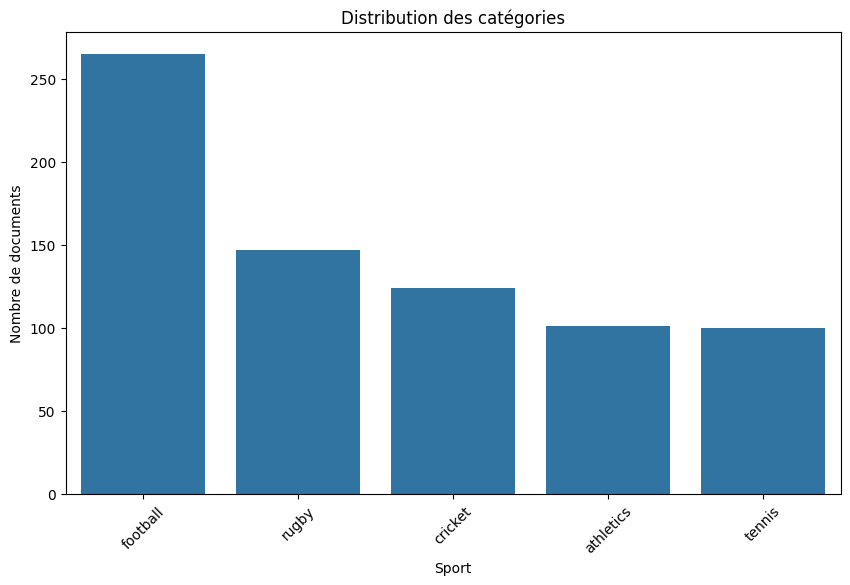

In [4]:
def plot_distribuition_categories(titre='Distribution des catégories'):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='sport', order=df['sport'].value_counts().index)
    plt.title(titre)
    plt.xlabel('Sport')
    plt.ylabel('Nombre de documents')
    plt.xticks(rotation=45)
    plt.show()

plot_distribuition_categories()

Le jeu de données présente un déséquilibre important, avec une forte représentation du football. Pour remédier à cela, nous allons procéder à un undersampling, en réduisant le nombre d'exemples pour le football à celui de la catégorie la moins représentée, à savoir le tennis.

In [5]:
# Trouvez la classe avec le moins d'exemples
classe_la_plus_petite = df['sport'].value_counts().idxmin()
nb_exemples_classe_la_plus_petite = df['sport'].value_counts().min()

print(f"Classe avec le moins d'exemples: {classe_la_plus_petite} ({nb_exemples_classe_la_plus_petite} exemples)")

# Créez un dictionnaire pour stocker les exemples de chaque classe
exemples_par_classe = {}

# Pour chaque classe, sélectionnez aléatoirement le même nombre d'exemples que la classe la plus petite
for classe in df['sport'].unique():
    exemples_par_classe[classe] = df[df['sport'] == classe].sample(nb_exemples_classe_la_plus_petite)

df = pd.concat(exemples_par_classe.values()).sample(frac=1, random_state=11)

df


Classe avec le moins d'exemples: tennis (100 exemples)


,sport,text
684,tennis,Classy Henman makes winning start\n\nTim Henma...
688,tennis,Bryan twins keep US hopes alive\n\nThe United ...
610,rugby,Tindall wants second opinion\n\nEngland centre...
391,football,McClaren eyes Uefa Cup top spot\n\nSteve McCla...
181,cricket,"Lee runs through Windies\n\nVB Series match 6,..."
...,...,...
162,cricket,Australia unchanged for Pakistan\n\nAustralia ...
537,rugby,O'Driscoll/Gregan lead Aid stars\n\nIreland's ...
628,rugby,Dominici backs lacklustre France\n\nWing Chris...
384,football,Anelka apologises for criticism\n\nManchester ...


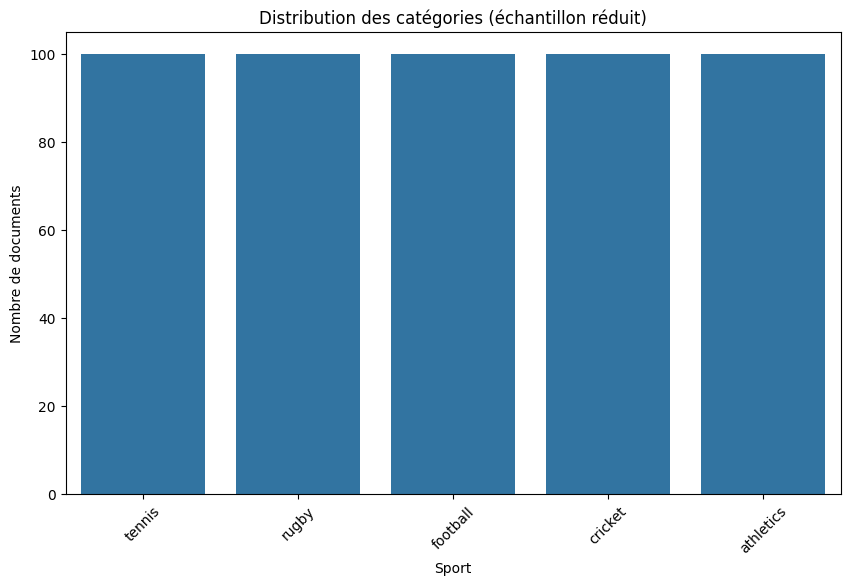

In [6]:
plot_distribuition_categories('Distribution des catégories (échantillon réduit)')

Nous pouvons observer que le jeu de données est désormais équilibré, avec un nombre égal d'échantillons (100) pour chaque catégorie de sport. Par ailleurs, les catégories sont désormais mélangées, ce qui évite tout ordre systématique qui pourrait introduire un biais.

# 4 . Prétraitement des données
Nettoyage du texte :

* Supprimer la ponctuation, les stopwords, les caractères spéciaux.

* Convertir le texte en minuscules.

* Lemmatisation

In [7]:
stop_words = set(stopwords.words('english'))
    
def nettoyer_texte(df, colonne_texte):
    
    def nettoyer_texte_unique(texte):
        texte = re.sub(r'[^\w\s]', '', texte)  # Supprimer la ponctuation
        texte = texte.lower()  # Convertir en minuscules
        tokens = word_tokenize(texte)  # Tokenisation
        tokens = [token for token in tokens if token not in stop_words]  # Supprimer les stopwords
        return ' '.join(tokens)
    
    df['texte_nettoye'] = df[colonne_texte].apply(nettoyer_texte_unique)
    return df

df = nettoyer_texte(df, "text")

df


,sport,text,texte_nettoye
684,tennis,Classy Henman makes winning start\n\nTim Henma...,classy henman makes winning start tim henman o...
688,tennis,Bryan twins keep US hopes alive\n\nThe United ...,bryan twins keep us hopes alive united states ...
610,rugby,Tindall wants second opinion\n\nEngland centre...,tindall wants second opinion england centre mi...
391,football,McClaren eyes Uefa Cup top spot\n\nSteve McCla...,mcclaren eyes uefa cup top spot steve mcclaren...
181,cricket,"Lee runs through Windies\n\nVB Series match 6,...",lee runs windies vb series match 6 adelaide au...
...,...,...,...
162,cricket,Australia unchanged for Pakistan\n\nAustralia ...,australia unchanged pakistan australia named u...
537,rugby,O'Driscoll/Gregan lead Aid stars\n\nIreland's ...,odriscollgregan lead aid stars irelands brian ...
628,rugby,Dominici backs lacklustre France\n\nWing Chris...,dominici backs lacklustre france wing christop...
384,football,Anelka apologises for criticism\n\nManchester ...,anelka apologises criticism manchester city st...


## 4.1 Extraction de features



In [8]:
# La fonction calculer_entropie permet de calculer l'entropie d'un texte donné.
# L'entropie est une mesure de la complexité ou de la variabilité d'un système, 
# dans ce cas, d'un texte.
def calculer_entropie(text):
    mots = text.split()
    compteur = Counter(mots)
    probas = [freq / len(mots) for freq in compteur.values()]
    return -np.sum(probas * np.log2(probas))

def extrair_features(df: pd.DataFrame) -> pd.DataFrame:
    df["num_lignes"] = df["text"].map(lambda text: text.count("\n\n"))  
    df["text"] = df["text"].map(lambda text: text.replace("\n\n", " "))

    df['longueur_texte'] = df['text'].apply(len)
    df['num_mots'] = df['text'].map(lambda x: len(x.split()))
    df['num_caracteres_avec_espaces'] = df['text'].map(lambda x: len(x))
    df['longueur_moyenne_mots'] = df['text'].map(lambda x: sum(len(word) for word in x.split()) / len(x.split()))
    df['stopwords'] = df['text'].map(lambda x: len([z for z in x.split() if z in stop_words]))
    df['mots_chiffres'] = df['text'].map(lambda x: len([z for z in x.split() if z.isdigit()]))
    df['entropie'] = df['text'].apply(calculer_entropie)
    df['richesse_lexicale'] = df['text'].apply(lambda x: len(set(x.split())) / len(x.split()))
    df['mots_uniques'] = df['text'].apply(lambda x: len(set(x.split())))
    df['nombre_majuscules'] = df['text'].apply(lambda x: sum(1 for mot in x.split() if mot.istitle()))
    df['nombre_ponctuations'] = df['text'].apply(lambda x: sum(1 for char in x if char in string.punctuation))

    return df

df = extrair_features(df)

df[["text", "texte_nettoye", "num_lignes"]]

,text,texte_nettoye,num_lignes
684,Classy Henman makes winning start Tim Henman o...,classy henman makes winning start tim henman o...,4
688,Bryan twins keep US hopes alive The United Sta...,bryan twins keep us hopes alive united states ...,3
610,Tindall wants second opinion England centre Mi...,tindall wants second opinion england centre mi...,4
391,McClaren eyes Uefa Cup top spot Steve McClaren...,mcclaren eyes uefa cup top spot steve mcclaren...,2
181,"Lee runs through Windies VB Series match 6, Ad...",lee runs windies vb series match 6 adelaide au...,7
...,...,...,...
162,Australia unchanged for Pakistan Australia hav...,australia unchanged pakistan australia named u...,3
537,O'Driscoll/Gregan lead Aid stars Ireland's Bri...,odriscollgregan lead aid stars irelands brian ...,6
628,Dominici backs lacklustre France Wing Christop...,dominici backs lacklustre france wing christop...,4
384,Anelka apologises for criticism Manchester Cit...,anelka apologises criticism manchester city st...,3


In [9]:
def apply_stemming(df, text_column, new_column_name="stemmed_text"):
    stemmer = PorterStemmer()
    
    def stem_text(text):
        tokens = word_tokenize(text)  # Tokenisation du texte
        stemmed_tokens = [stemmer.stem(token) for token in tokens]  # Stemming
        return " ".join(stemmed_tokens)  # Rejoindre les tokens en une chaîne
    
    df[new_column_name] = df[text_column].apply(stem_text)
    return df

def apply_lemmatization_nltk(df, text_column, new_column_name="lemmatized_text"):
    
    lemmatizer = WordNetLemmatizer()
    
    def lemmatize_text(text):
        tokens = word_tokenize(text)  # Tokenisation du texte
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatisation
        return " ".join(lemmatized_tokens)  # Rejoindre les tokens en une chaîne
    
    df[new_column_name] = df[text_column].apply(lemmatize_text)
    return df

# Appliquer le stemming
df = apply_stemming(df, text_column="texte_nettoye", new_column_name="Stemmed_Text")

# Appliquer la lemmatisation avec NLTK
df = apply_lemmatization_nltk(df, text_column="texte_nettoye", new_column_name="Lemmatized_Text_NLTK")

df


,sport,text,texte_nettoye,num_lignes,longueur_texte,num_mots,num_caracteres_avec_espaces,longueur_moyenne_mots,stopwords,mots_chiffres,entropie,richesse_lexicale,mots_uniques,nombre_majuscules,nombre_ponctuations,Stemmed_Text,Lemmatized_Text_NLTK
684,tennis,Classy Henman makes winning start Tim Henman o...,classy henman makes winning start tim henman o...,4,2246,401,2246,4.600998,148,2,7.457655,0.618454,248,71,83,classi henman make win start tim henman open 2...,classy henman make winning start tim henman op...
688,tennis,Bryan twins keep US hopes alive The United Sta...,bryan twins keep us hopes alive united states ...,3,1985,351,1985,4.655271,127,0,7.365218,0.626781,220,70,63,bryan twin keep us hope aliv unit state kept d...,bryan twin keep u hope alive united state kept...
610,rugby,Tindall wants second opinion England centre Mi...,tindall wants second opinion england centre mi...,4,1104,189,1104,4.841270,68,2,6.701342,0.708995,134,44,25,tindal want second opinion england centr mike ...,tindall want second opinion england centre mik...
391,football,McClaren eyes Uefa Cup top spot Steve McClaren...,mcclaren eyes uefa cup top spot steve mcclaren...,2,873,153,873,4.705882,65,0,6.427090,0.679739,104,24,25,mcclaren eye uefa cup top spot steve mcclaren ...,mcclaren eye uefa cup top spot steve mcclaren ...
181,cricket,"Lee runs through Windies VB Series match 6, Ad...",lee runs windies vb series match 6 adelaide au...,7,3556,613,3556,4.800979,199,17,7.934028,0.572594,351,156,103,lee run windi vb seri match 6 adelaid australi...,lee run windies vb series match 6 adelaide aus...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,cricket,Australia unchanged for Pakistan Australia hav...,australia unchanged pakistan australia named u...,3,792,125,792,5.336000,36,0,6.276338,0.712000,89,46,23,australia unchang pakistan australia name unch...,australia unchanged pakistan australia named u...
537,rugby,O'Driscoll/Gregan lead Aid stars Ireland's Bri...,odriscollgregan lead aid stars irelands brian ...,6,3026,511,3026,4.921722,131,2,8.008730,0.653620,334,225,181,odriscollgregan lead aid star ireland brian od...,odriscollgregan lead aid star ireland brian od...
628,rugby,Dominici backs lacklustre France Wing Christop...,dominici backs lacklustre france wing christop...,4,1831,314,1831,4.831210,122,2,7.362209,0.678344,213,72,45,dominici back lacklustr franc wing christoph d...,dominici back lacklustre france wing christoph...
384,football,Anelka apologises for criticism Manchester Cit...,anelka apologises criticism manchester city st...,3,2350,444,2350,4.292793,198,0,7.327325,0.524775,233,75,70,anelka apologis critic manchest citi striker n...,anelka apologises criticism manchester city st...


Remarques
Stemming : Moins précis que la lemmatisation, mais plus rapide.

Lemmatisation : Plus précis, mais nécessite des ressources supplémentaires (comme un modèle de langue pour spaCy).

## **4.2 Exploration des données après extraction des caractéristiques du texte**
- **Statistiques descriptives** :
  - Nombre total de documents.
  - Longueur moyenne des textes par catégorie.
  - Distribution des catégories (visualisation avec Matplotlib/Seaborn).
- **Analyse textuelle** :
  - Fréquence des mots par catégorie (utiliser `TextHero` ou `CountVectorizer`).
  - Nuages de mots (`wordcloud`) pour chaque catégorie.

In [10]:
total_documents = df.shape[0]
print(f"Nombre total de documents : {total_documents}")

Nombre total de documents : 500


In [11]:
df_numerique = df.select_dtypes(include=['int64', 'float64'])
df_pivot = df_numerique.pivot_table(index=df['sport'], aggfunc='mean')
df_pivot

,entropie,longueur_moyenne_mots,longueur_texte,mots_chiffres,mots_uniques,nombre_majuscules,nombre_ponctuations,num_caracteres_avec_espaces,num_lignes,num_mots,richesse_lexicale,stopwords
sport,,,,,,,,,,,,
athletics,7.002790,4.859038,1784.62,1.53,188.83,52.75,48.79,1784.62,3.96,306.50,0.651858,119.63
cricket,7.321152,4.816122,2118.50,4.93,228.97,75.99,65.46,2118.50,4.78,366.55,0.645973,134.91
football,7.097667,4.708570,1890.98,1.62,199.41,59.21,55.57,1890.98,4.24,334.20,0.630469,136.98
rugby,7.282613,4.828439,2120.23,1.97,224.41,80.24,72.58,2120.23,4.55,366.07,0.637803,138.73
tennis,6.993732,4.652581,1602.91,2.09,178.57,52.13,53.73,1602.91,4.00,284.49,0.661154,106.77


### Observations générales
- La table contient des données linguistiques et statistiques pour différents sports : **athletics**, **cricket**, **football**, **rugby**, et **tennis**.
- Les colonnes incluent des métriques telles que l'entropie, la longueur moyenne des mots, la longueur du texte, le nombre de mots uniques, etc.

### Points clés par colonne

#### Entropie
- **Cricket** a l'entropie la plus élevée (7.332), indiquant une plus grande diversité lexicale.
- **Tennis** a l'entropie la plus faible (6.994), suggérant une moindre diversité lexicale.

#### Longueur moyenne des mots
- La longueur moyenne des mots est relativement similaire pour tous les sports, variant entre **4.65** (tennis) et **4.86** (athletics).
- **Athletics** a les mots les plus longs en moyenne.

#### Longueur du texte
- **Cricket** a le texte le plus long (2191.69), suivi de **rugby** (2097.76).
- **Tennis** a le texte le plus court (1602.91).

#### Mots chiffres
- **Cricket** contient le plus de mots chiffres (4.92), ce qui pourrait indiquer une utilisation plus fréquente de statistiques ou de données numériques.
- **Athletics** et **football** en ont le moins (1.52 et 1.69 respectivement).

#### Mots uniques
- **Cricket** a le plus grand nombre de mots uniques (233.70), suivi de **rugby** (222.52).
- **Tennis** a le moins de mots uniques (178.57).

#### Nombre de majuscules
- **Rugby** a le plus de majuscules (82.05), peut-être dû à des noms propres ou acronymes.
- **Tennis** en a le moins (52.13).

#### Nombre de ponctuations
- **Rugby** a le plus de ponctuations (72.63), suivi de **cricket** (66.95).
- **Tennis** en a le moins (53.73).

#### Nombre de caractères (avec espaces)
- Les valeurs sont identiques à la longueur du texte, car cette colonne semble être une redondance.

#### Nombre de lignes
- **Cricket** a le plus de lignes (5.66), tandis que **tennis** en a le moins (4.00).

#### Nombre de mots
- **Cricket** a le plus de mots (378.83), suivi de **rugby** (360.84).
- **Tennis** a le moins de mots (284.49).

#### Richesse lexicale
- **Tennis** a la richesse lexicale la plus élevée (0.661), indiquant une plus grande variété de vocabulaire par rapport au nombre total de mots.
- **Football** a la richesse lexicale la plus faible (0.627).

#### Stopwords
- **Cricket** a le plus de stopwords (138.04), suivi de **football** (142.66).
- **Tennis** en a le moins (106.77).

### Conclusion
- **Cricket** se distingue par une plus grande complexité linguistique (entropie élevée, plus de mots uniques, plus de stopwords).
- **Tennis** a tendance à être plus concis avec une richesse lexicale plus élevée mais moins de diversité globale.
- **Rugby** et **football** se situent dans une fourchette intermédiaire, avec des caractéristiques linguistiques équilibrées.

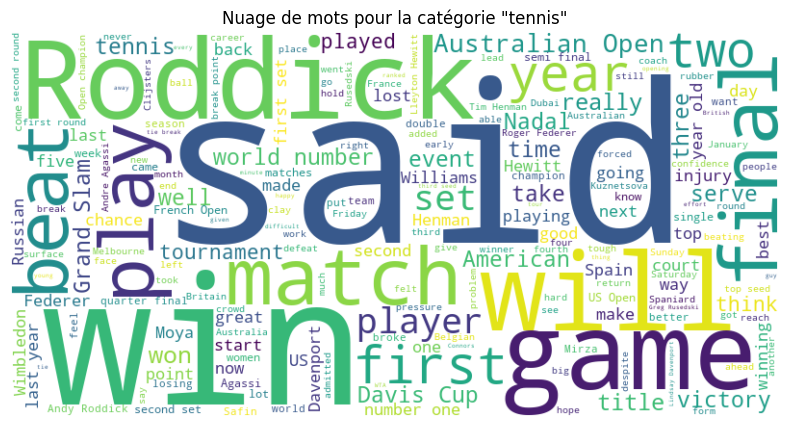

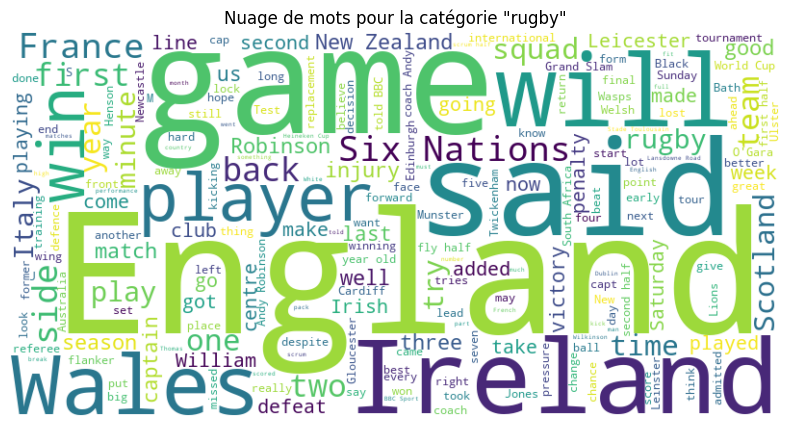

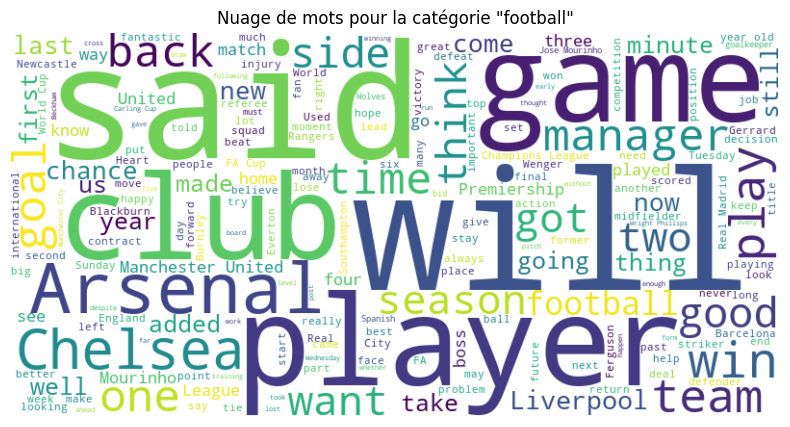

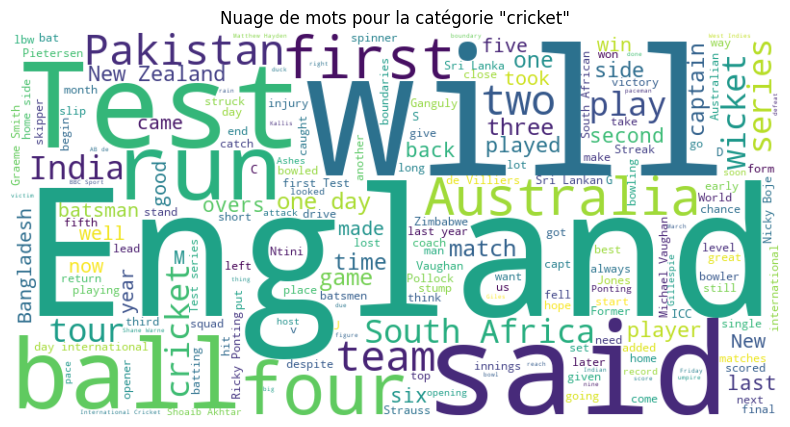

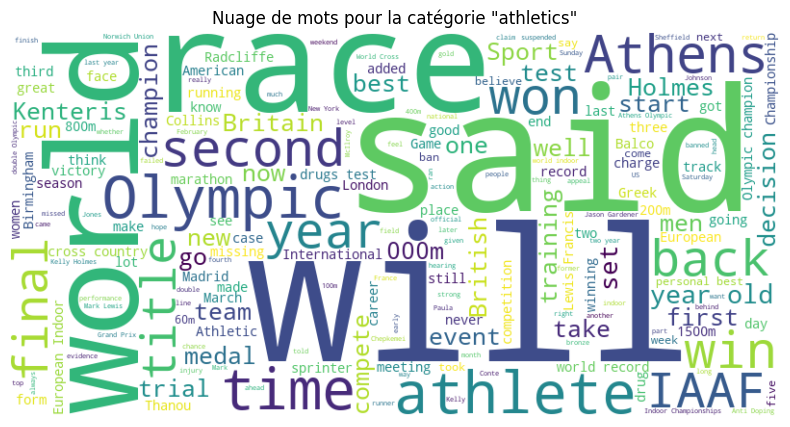

In [12]:
from wordcloud import WordCloud

# Générer un nuage de mots pour chaque catégorie
for category in df['sport'].unique():
    texts = " ".join(df[df['sport'] == category]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texts)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Nuage de mots pour la catégorie "{category}"')
    plt.axis('off')
    plt.show()

# **5. Modélisation**

## Approche 1

Ce code utilise une technique d'extraction de caractéristiques textuelles (TF-IDF Vectors) et applique quatre algorithmes de classification différents : Naive Bayes, Complement Naive Bayes, Régression Logistique, SVM et Random Forest. L'objectif est de comparer les performances de ces modèles en se basant sur la même technique d'extraction. Les étapes principales sont :

1. **Extraction des Caractéristiques** :  
   - Le texte est transformé en vecteurs TF-IDF.  

2. **Classification** :  
   - Cinque modèles sont entraînés et évalués : Naive Bayes, Complement Naive Bayes, Régression Logistique, SVM et Random Forest.  

3. **Comparaison** :  
   - Les performances des modèles sont comparées en utilisant des métriques comme le score F1 et les temps d'exécution.  

En résumé, ce code permet de comparer trois modèles de classification en utilisant une technique d'extraction commune (TF-IDF).

In [13]:
def pretraiter_donnees(nom_modele, X_train, X_test, colonne_texte):
    if nom_modele in ["Naive Bayes", "Complement Naive Bayes", "Régression Logistique", "SVM", "Random Forest"]:
        preprocesseur = ColumnTransformer(
            transformers=[
                ('texte', TfidfVectorizer(), colonne_texte)
            ]
        )
    else:
        raise ValueError(f"Modèle inconnu : {nom_modele}")

    X_train_pretraite = preprocesseur.fit_transform(X_train)
    X_test_pretraite = preprocesseur.transform(X_test)
    return X_train_pretraite, X_test_pretraite, preprocesseur

def evaluer_modele(nom, modele, X_train, X_test, y_train, y_test, colonne_texte):
    with mlflow.start_run(run_name=nom, nested=True):
        X_train_pretraite, X_test_pretraite, preprocesseur = pretraiter_donnees(nom, X_train, X_test, colonne_texte)

        debut_entrainement = time.time()
        modele.fit(X_train_pretraite, y_train)
        temps_entrainement = time.time() - debut_entrainement

        scores_cv = cross_val_score(modele, X_train_pretraite, y_train, cv=5, scoring='f1_weighted')
        f1_moyen_cv = scores_cv.mean()

        debut_prediction = time.time()
        y_pred = modele.predict(X_test_pretraite)
        temps_prediction = time.time() - debut_prediction

        f1_test = f1_score(y_test, y_pred, average='weighted')

        print(f"\n{nom} - Rapport de classification :")
        print(classification_report(y_test, y_pred, zero_division=0))

        mlflow.log_metric("F1_Score_Test", f1_test)
        mlflow.log_metric("F1_Score_CV", f1_moyen_cv)
        mlflow.log_metric("Temps_entrainement_s", temps_entrainement)
        mlflow.log_metric("Temps_prediction_s", temps_prediction)

        mlflow.log_param("n_lignes_dataset", df.shape[0])
        mlflow.log_param("n_lignes_entrainement", X_train.shape[0])
        mlflow.log_param("n_lignes_test", X_test.shape[0])
        mlflow.log_param("mlflow.note.content", "Approche 1 - TF-IDF Vectors avec 4 modèles de classification")

        mlflow.log_artifact(notebook_path, "notebook")
        mlflow.log_table(data= df, artifact_file="df_avec_caracteristics.json")

        df_y_true_y_pred = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
        mlflow.log_table(df_y_true_y_pred, 'y_true_y_pred.json')
    
        signature = infer_signature(X_train, y_train)
        mlflow.sklearn.log_model(modele, nom, signature=signature)

        return {
            "F1 (Test)": f1_test,
            "F1 (CV)": f1_moyen_cv,
            "Temps d'entraînement (s)": temps_entrainement,
            "Temps de prédiction (s)": temps_prediction
        }

# Colonnes de données
colonne_texte = 'Stemmed_Text'

# Modèles à évaluer
modeles = {
    "Naive Bayes": MultinomialNB(),
    "Complement Naive Bayes": ComplementNB(),
    "Régression Logistique": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42) 
}

# Séparation des données
X = df.drop(['sport'], axis=1)
y = df['sport']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Évaluation des modèles
mlflow.set_experiment("Approche 1 - TF-IDF Vectors avec 4 modèles de classification")
resultats = {}
for nom, modele in modeles.items():
    resultats[nom] = evaluer_modele(nom, modele, X_train, X_test, y_train, y_test, colonne_texte)

# Affichage des résultats
resultats_df = pd.DataFrame(resultats).T
print("\nComparaison des modèles :")
print(resultats_df)



Naive Bayes - Rapport de classification :
              precision    recall  f1-score   support

   athletics       1.00      1.00      1.00        20
     cricket       1.00      0.95      0.97        20
    football       1.00      0.95      0.97        20
       rugby       0.91      1.00      0.95        20
      tennis       1.00      1.00      1.00        20

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100


Complement Naive Bayes - Rapport de classification :
              precision    recall  f1-score   support

   athletics       1.00      0.95      0.97        20
     cricket       1.00      1.00      1.00        20
    football       1.00      0.95      0.97        20
       rugby       0.91      1.00      0.95        20
      tennis       1.00      1.00      1.00        20

    accuracy                           0.98       100
   macro avg       0.98      0.98 

### Approche 2 - Random Forest avec 4 sources de données

Ce code applique le modèle **Complement Naive Bayes** sur quatre types de sources de données pour comparer leurs performances. Les étapes principales sont :

1. **Sources de Données** :
   - **Colonnes Numériques** : Utilisation des caractéristiques numériques normalisées avec `MinMaxScaler`.
   - **Word Count Vectors** : Transformation du texte en vecteurs de comptage de mots avec `CountVectorizer`.
   - **TF-IDF Vectors** : Transformation du texte en vecteurs TF-IDF avec `TfidfVectorizer`.
   - **Word Embeddings** : Utilisation des embeddings de mots générés par spaCy, normalisés avec `MinMaxScaler`.

2. **Évaluation** :
   - Chaque source est évaluée avec **Random Forest** en utilisant la validation croisée et le score F1 pondéré.
   - Les résultats (F1 Score, temps d'exécution) sont enregistrés dans **MLflow** pour comparaison.

3. **Résultats** :
   - Les performances sont comparées pour chaque source, avec un focus sur le score F1 et les temps d'entraînement/prédiction.

En résumé, ce code permet de comparer l'efficacité de différentes techniques d'extraction de caractéristiques avec **Random Forest**.

In [ ]:
# Colonnes numériques
colonnes_numeriques = [
    "entropie", "longueur_moyenne_mots", "longueur_texte", "mots_chiffres",
    "mots_uniques", "nombre_majuscules", "nombre_ponctuations",
    "num_caracteres_avec_espaces", "num_lignes", "num_mots",
    "richesse_lexicale", "stopwords"
]

# Colonne de texte
colonne_texte = "Stemmed_Text"

# Séparation des données
X = df.drop(columns=["sport"])  # Caractéristiques
y = df["sport"]  # Étiquettes

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fonction pour évaluer et enregistrer les résultats
def evaluer_modele(nom_source, X_train, X_test, y_train, y_test, preprocesseur):
    with mlflow.start_run(run_name=f"RandomForest_{nom_source}"):
        # Créer le pipeline
        modele = RandomForestClassifier(n_estimators=100, random_state=42) 
        pipeline = Pipeline(steps=[
            ("preprocesseur", preprocesseur),
            ("modele", modele)
        ])

        # Entraînement du modèle
        debut_entrainement = time.time()
        pipeline.fit(X_train, y_train)
        temps_entrainement = time.time() - debut_entrainement

        # Validation croisée
        scores_cv = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="f1_weighted")
        f1_moyen_cv = scores_cv.mean()

        # Prédiction sur l'ensemble de test
        debut_prediction = time.time()
        y_pred = pipeline.predict(X_test)
        temps_prediction = time.time() - debut_prediction

        # Calcul du score F1 sur l'ensemble de test
        f1_test = f1_score(y_test, y_pred, average="weighted")

        # Affichage des résultats
        print(f"\nRésultats pour {nom_source}:")
        print(f"F1 Score (Test): {f1_test}")
        print(f"F1 Score (CV): {f1_moyen_cv}")
        print(f"Temps d'entraînement (s): {temps_entrainement}")
        print(f"Temps de prédiction (s): {temps_prediction}")
        print("\nRapport de classification :")
        print(classification_report(y_test, y_pred, zero_division=0))

        # Enregistrement des métriques dans MLflow
        mlflow.log_metric("F1_Score_Test", f1_test)
        mlflow.log_metric("F1_Score_CV", f1_moyen_cv)
        mlflow.log_metric("Temps_entrainement_s", temps_entrainement)
        mlflow.log_metric("Temps_prediction_s", temps_prediction)

        mlflow.log_param("n_lignes_dataset", df.shape[0])
        mlflow.log_param("n_lignes_entrainement", X_train.shape[0])
        mlflow.log_param("n_lignes_test", X_test.shape[0])
        mlflow.log_param("mlflow.note.content", "Approche 2 - Random Forest avec 4 sources de données")

        mlflow.log_artifact(notebook_path, "notebook")
        mlflow.log_table(data= df, artifact_file="df_avec_caracteristics.json")

        df_y_true_y_pred = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
        mlflow.log_table(df_y_true_y_pred, 'y_true_y_pred.json')
    

        # Enregistrement du modèle dans MLflow
        signature = infer_signature(X_train, y_train)
        mlflow.sklearn.log_model(pipeline, nom_source, signature=signature)

mlflow.set_experiment("Approche 2 - RandomForest avec 4 sources de données")
# 1. Source : Colonnes numériques
# RandomForest n'accepte que des valeurs positives, 
# a cause de la nature de la distribution de nos données, 
# on va utiliser MinMaxScaler, entre 0 et 1
preprocesseur_numerique = ColumnTransformer(
    transformers=[
        ("numeriques", MinMaxScaler(), colonnes_numeriques)
    ]
)

evaluer_modele("Colonnes_Numeriques", X_train, X_test, y_train, y_test, preprocesseur_numerique)

# 2. Source : Word Count Vectors
preprocesseur_word_count = ColumnTransformer(
    transformers=[
        ("texte", CountVectorizer(), colonne_texte)
    ]
)
evaluer_modele("Word_Count_Vectors", X_train, X_test, y_train, y_test, preprocesseur_word_count)

# 3. Source : TF-IDF Vectors
preprocesseur_tfidf = ColumnTransformer(
    transformers=[
        ("texte", TfidfVectorizer(), colonne_texte)
    ]
)
evaluer_modele("TFIDF_Vectors", X_train, X_test, y_train, y_test, preprocesseur_tfidf)

# 4. Source : Word Embeddings (exemple avec un modèle pré-entraîné comme Word2Vec)

# Transformer le texte en embeddings avec MinMaxScaler
class SpacyEmbeddingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp_model):
        self.nlp_model = nlp_model
        self.scaler = MinMaxScaler()  # Ajouter un scaler pour normaliser entre 0 et 1

    def transform(self, X, y=None):
        embeddings = np.array([np.mean([token.vector for token in self.nlp_model(text)], axis=0) for text in X])
        return self.scaler.fit_transform(embeddings)  # Appliquer MinMaxScaler

    def fit(self, X, y=None):
        return self

# Appliquer le transformateur
preprocesseur_word_embeddings = ColumnTransformer(
    transformers=[
        ("texte", SpacyEmbeddingTransformer(nlp), colonne_texte)
    ]
)

# Évaluer le modèle
evaluer_modele("Word_Embeddings_spaCy", X_train, X_test, y_train, y_test, preprocesseur_word_embeddings)


Résultats pour Colonnes_Numeriques:
F1 Score (Test): 0.3612349299446073
F1 Score (CV): 0.3869264069853021
Temps d'entraînement (s): 0.2102961540222168
Temps de prédiction (s): 0.012854337692260742

Rapport de classification :
              precision    recall  f1-score   support

   athletics       0.40      0.50      0.44        20
     cricket       0.50      0.50      0.50        20
    football       0.29      0.35      0.32        20
       rugby       0.27      0.15      0.19        20
      tennis       0.35      0.35      0.35        20

    accuracy                           0.37       100
   macro avg       0.36      0.37      0.36       100
weighted avg       0.36      0.37      0.36       100


Résultats pour Word_Count_Vectors:
F1 Score (Test): 0.9296370852083305
F1 Score (CV): 0.9625983872687984
Temps d'entraînement (s): 0.4281880855560303
Temps de prédiction (s): 0.027587413787841797

Rapport de classification :
              precision    recall  f1-score   support

   

In [15]:
#!mlflow ui